# Import libraries

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import os
import h5py
import matplotlib as mpl
from scipy.stats import halfnorm
import copy
import glob
import zipfile

In [ ]:
import pytrip as pt
from pytrip.volhist import VolHist 
from dicompylercore import dicomparser, dvh, dvhcalc

In [ ]:
import pylab

# Functions

In [ ]:
def rbe_wedenberg(dose, let, abx,q):
    """
    Wedenberg proton RBE model
    input parameters may be either numpy.array or scalars
    TODO: handle Cube() class directly
    :params dose: physical proton dose in [Gy]
    :params let: LETd in [keV/um] (protons only)
    :params abx: alpha_x / beta_x [Gy]
    :returns: RBE for the given parameters
    :ref: http://dx.doi.org/10.3109/0284186X.2012.705892
    """

    _apx = 1.000 + q * let / abx
    _sbpx = 1.0

    rbe = _rbe_apx(dose, _apx, _sbpx, abx)
    return rbe

In [ ]:
def _rbe_apx(dose, apx, sbpx, abx, dzero=0.0):
    """
    :params dose: proton dose      [Gy]
    :params apx: alpha_p / alpha_x [dimensionless] RBE_max = ap/ax when (dose -> 0 Gy)
    :params sbpx: beta_p / beta_x  [dimensionless] RBE_min = sqrt(bp/bx) when (dose -> inf Gy)
    :params abx: alpha_x / beta_x  [Gy]
    :params dzero: what to return in case of dose is zero (which would cause division by zero)
    """

    _rbe = 1.0 / (2.0 * dose)
    if hasattr(_rbe, '__iter__'):
        _rbe[_rbe == np.inf] = dzero
    else:
        if _rbe == np.inf:
            return dzero
    delta = abx * abx + 4. * abx * apx * dose + 4. * sbpx * sbpx * dose * dose
    delta *= (delta > 0)
    _rbe *= (np.sqrt(delta) - abx)
    return _rbe

In [ ]:
def biological_dose (q,ab,dos_cube,let_cube):
    result = pt.DosCube()
    result.cube = rbe_wedenberg(dos_cube.cube, let_cube.cube, ab, q) * dos_cube.cube
    return result

In [ ]:
def plot_style():
    plt.grid()
    plt.minorticks_on()
    plt.grid(which='minor', linestyle=':', linewidth='0.2', color='k')

    plt.rcParams['xtick.direction'] = 'in' 
    plt.rcParams['ytick.direction'] = 'in' 
    plt.rcParams['xtick.top'] = True 
    plt.rcParams['ytick.right'] = True  

    params = {'legend.fontsize': '20',
         'figure.figsize': (16,8),
         'axes.labelsize': '26',
         'axes.titlesize':'26',
         'xtick.labelsize':'20',
         'ytick.labelsize':'20',
         'xtick.major.pad':'16',
         'ytick.major.pad':'16'}
    
    pylab.rcParams.update(params)

In [ ]:
def calculate_dvh (qval, ab, dose_cube,let_cube,mask,target_voi, bins , dose_pres, fraction):
    
    biol_dose= rbe_wedenberg(dose=dose_cube.cube[mask], let=let_cube.cube[mask], abx=ab, q=qval) * dose_cube.cube[mask]

    _xrange = (0.0,2.4)
    _hist, x = np.histogram((biol_dose), bins=1024, range=_xrange,density=True)
    _fhist = _hist[::-1]  # reverse histogram, so first element is for highest dose
    _fhist = np.cumsum(_fhist)
    _hist = _fhist[::-1]  # flip back again to normal representation

    y = 100.0 * _hist / _hist[0]  # volume histograms always plot the right edge of bin, since V(D < x_pos).
    y = np.insert(y, 0, 100.0, axis=0)  # but the leading bin edge is always at V = 100.0%
    return(x,y)    

In [ ]:
def plot_dvh ( dose_cube, bins ):
   

    _hist, x = np.histogram(dose_cube, bins=bins, density=True)
    _fhist = _hist[::-1]  # reverse histogram, so first element is for highest dose
    _fhist = np.cumsum(_fhist)
    _hist = _fhist[::-1]  # flip back again to normal representation

    y = 100.0 * _hist / _hist[0]  # volume histograms always plot the right edge of bin, since V(D < x_pos).
    y = np.insert(y, 0, 100.0, axis=0)  # but the leading bin edge is always at V = 100.0%
    return(x,y)    

In [ ]:
def plot_dvh_xrange ( dose_cube,bins = 1024):
   
    _xrange=(0,2.4)
    _hist, x = np.histogram(dose_cube, bins=bins,range=_xrange, density=True)
    _fhist = _hist[::-1]  # reverse histogram, so first element is for highest dose
    _fhist = np.cumsum(_fhist)
    _hist = _fhist[::-1]  # flip back again to normal representation

    y = 100.0 * _hist / _hist[0]  # volume histograms always plot the right edge of bin, since V(D < x_pos).
    y = np.insert(y, 0, 100.0, axis=0)  # but the leading bin edge is always at V = 100.0%
    return(x,y)  

# Read data

In [ ]:
with zipfile. ZipFile("data/pancreas_inspire.zip","r") as zip_ref:
    zip_ref. extractall("tmp")

In [ ]:
with zipfile. ZipFile("data/pancreas_eclipse.zip","r") as zip_ref:
    zip_ref. extractall("tmp")

In [ ]:
fname = os.path.join('tmp','distrib_q.h5')
q_val = pd.read_hdf(fname, 'q',columns=['q'])

In [ ]:
#ECLIPSE DVH
#dla planu z eclipse
dvh_eclipse_read = pd.read_csv("data/DVH_iCTV5580.txt", sep=" ",delimiter="\s+", header=None)

In [ ]:
dvh_eclipse = dvh_eclipse_read.iloc[1:-1 , 0:3]
dvh_eclipse.reset_index(drop=True, inplace=True)
dvh_eclipse.rename(columns={dvh_eclipse.columns[0]:"Dose",
                            dvh_eclipse.columns[1]:"Relative_Dose",
                            dvh_eclipse.columns[2]:"Volume"},
                   inplace=True)
dvh_eclipse=dvh_eclipse.astype('float')
dvh_eclipse.Dose=dvh_eclipse.Dose/fraction/1.1

In [ ]:
rs = "data/RS.Patient07_Plan1.dcm"
rd = "data/RD.Patient07_Plan1.dcm"

In [ ]:
patient_org = 'pancreas_inspire'
patient_mod = 'pancreas_eclipse'

# Prescribed dose and number of fractionation

In [ ]:
## Choose alpha/beta ratio == 2.0 or 10.0

dose_pres = 55.8 
fraction=31.
dose_per_fr=dose_pres/fraction
dose_per_fr_ph= dose_per_fr/1.1
ab=2.

# Patient: Eclipse Data

Structure: iCTV_5580
Approval Status: Unapproved
Plan: Plan_MG1
Course: MG
Volume [cm³]: 76.0
Dose Cover.[%]: 100.0
Sampling Cover.[%]: 100.0
Min Dose [Gy]: 53.530
Max Dose [Gy]: 55.705
Mean Dose [Gy]: 55.116
Modal Dose [Gy]: 55.161
Median Dose [Gy]: 55.164
STD [Gy]: 0.239
Equiv. Sphere Diam. [cm]: 5.3
Conformity Index: 0.00
Gradient Measure [cm]: 4.10

In [ ]:
dp = dicomparser.DicomParser(rs)
# i.e. Get a dict of structure information
structures = dp.GetStructures()
#structures

In [ ]:
#choose structure from DICOM
for id, organ in structures.items():  
    
    for name, k in organ.items():
      if k == 'iCTV_5580':
        print(id)
        structure_id=id

In [ ]:
# Access DVH data
# get structure Volume
calcdvh = dvhcalc.get_dvh(rs,rd,structure_id)
structure_volume=calcdvh.volume
print(" Max dose: ",calcdvh.max,"\n Min dose: ", calcdvh.min,"\n Mean dose: ",calcdvh.mean,"\n Dose in 2%Volume: ", calcdvh.D99cc, "\n Volume[cm^3]: ",calcdvh.volume)

# Patient: PyTrip Data

In [ ]:
#FIRST CASE
#Inspire angles
patient_name = 'inspire07pancreas'
file_corename = os.path.join('tmp',patient_org,patient_org, patient_name)

dos_cube = pt.DosCube()
dos_cube.read(file_corename)
dos_cube.cube = dos_cube.cube.astype(np.float64)
dos_cube.cube /= 1000.0
dos_cube.cube *= dose_per_fr_ph

let_cube = pt.LETCube()
let_cube.read(file_corename)

ctx_cube = pt.CtxCube()
ctx_cube.read(file_corename)

vdx_cube = pt.VdxCube(ctx_cube)
vdx_cube.read(file_corename + '.vdx')

# index of point in original plan with highest dose
imax = np.unravel_index(dos_cube.cube.argmax(), dos_cube.cube.shape)
imax

In [ ]:
#SECOND CASE
#CCB angles
#difference between angles
patient_name = 'inspire07pancreas'
file_corename = os.path.join('tmp',patient_mod,patient_mod, patient_name)

dos_cube2 = pt.DosCube()
dos_cube2.read(file_corename)
dos_cube2.cube = dos_cube2.cube.astype(np.float64)
dos_cube2.cube /= 1000.0
dos_cube2.cube *= dose_per_fr_ph

let_cube2 = pt.LETCube()
let_cube2.read(file_corename)

ctx_cube2 = pt.CtxCube()
ctx_cube2.read(file_corename)

vdx_cube2 = pt.VdxCube(ctx_cube2)
vdx_cube2.read(file_corename + '.vdx')

In [ ]:
ctx_cube.slice_pos[imax[0]]

In [ ]:
print(vdx_cube.voi_names())

In [ ]:
contour_data = vdx_cube.get_voi_by_name('iCTV_5580').get_slice_at_pos(ctx_cube.slice_pos[imax[0]]).contours[0].contour
contour_liver = vdx_cube.get_voi_by_name('liver').get_slice_at_pos(ctx_cube.slice_pos[imax[0]]).contours[0].contour
contour_kidney_L = vdx_cube.get_voi_by_name('kidney_L').get_slice_at_pos(ctx_cube.slice_pos[imax[0]]).contours[0].contour
contour_kidney_R = vdx_cube.get_voi_by_name('kidney_R').get_slice_at_pos(ctx_cube.slice_pos[imax[0]]).contours[0].contour

In [ ]:
ctx_cube.yoffset

In [ ]:
ctx_cube.dimy

In [ ]:
dos_cube.pixel_size

In [ ]:
x = [item[0] / 10. for item in contour_data]
y = [item[1] / 10. for item in contour_data]
x_liv = [item[0] / 10. for item in contour_liver]
y_liv = [item[1] / 10. for item in contour_liver]
x_kidney_L = [item[0] / 10. for item in contour_kidney_L]
y_kidney_L = [item[1] / 10. for item in contour_kidney_L]
x_kidney_R = [item[0] / 10. for item in contour_kidney_R]
y_kidney_R = [item[1] / 10. for item in contour_kidney_R]

In [ ]:
#dose in patient

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(22,12))

pixel_mm = dos_cube.pixel_size/10.
im1 = ax1.imshow(dos_cube.cube[imax[0],:,:], 
                 cmap=cm.jet, interpolation='none', 
                 origin="lower",              #upper
                 extent=[ctx_cube.xoffset/10,ctx_cube.xoffset/10 + ctx_cube.dimx*pixel_mm,
                         ctx_cube.yoffset/10,ctx_cube.yoffset/10 + ctx_cube.dimy*pixel_mm])

im2 = ax2.imshow(dos_cube2.cube[imax[0],:,:], 
                 cmap=cm.jet, interpolation='none', 
                 origin='lower',
                 extent=[ctx_cube2.xoffset/10,ctx_cube2.xoffset/10 + ctx_cube2.dimx*pixel_mm,
                         ctx_cube2.yoffset/10,ctx_cube2.yoffset/10 + ctx_cube2.dimy*pixel_mm])


ax1.plot(x,y,c='y', label = "CTV")
ax2.plot(x,y,c='y', label = "CTV")
ax1.plot(x_liv,y_liv,c='g',label = "liver")
ax2.plot(x_liv,y_liv,c='g',label='liver')
ax1.plot(x_kidney_L,y_kidney_L, c='w',label = "left kidney")
ax2.plot(x_kidney_L,y_kidney_L, c='w',label = "left kidney")
ax1.plot(x_kidney_R,y_kidney_R, c='r',label = "right kidney")
ax2.plot(x_kidney_R,y_kidney_R, c='r',label = "right kidney")

ax1.set_xlabel('X [cm]',fontsize=15)
ax1.set_ylabel('Y [cm]',fontsize=15)
ax2.set_xlabel('X [cm]',fontsize=15)
ax2.set_ylabel('Y [cm]',fontsize=15)

ax1.set_title("pyTrip plan: INSPIRE angles",fontsize=20)
ax2.set_title("pyTrip plan: CCB angles",fontsize=20)

ax1.legend(title = "Irradiated organs",loc='best',fancybox=True, framealpha=0.6,prop={'size': 14}, title_fontsize=16)
ax2.legend(title = "Irradiated organs",loc='best',fancybox=True, framealpha=0.6,prop={'size': 14}, title_fontsize=16)

ax1.invert_yaxis()
ax2.invert_yaxis()


fig.colorbar(im1, ax=ax1, label ="Dose [Gy]", shrink = 0.5).set_label(label="Dose [Gy]", size=16, labelpad=-15, y=1.1, rotation=0)
fig.colorbar(im2, ax=ax2, label ="Dose [Gy]", shrink = 0.5 ).set_label(label="Dose [Gy]", size=16, labelpad=-15, y=1.1, rotation=0)

In [ ]:
#dose in patient
fig, (ax1) = plt.subplots(1,1, figsize=(16,12))
pixel_mm = dos_cube.pixel_size/10.

im1 = ax1.imshow(dos_cube2.cube[imax[0],:,:] - dos_cube.cube[imax[0],:,:], 
                 cmap=cm.seismic,vmin=-1.25,vmax=1.25,interpolation='none', 
                 origin="lower",              #upper
                 extent=[ctx_cube.xoffset/10,ctx_cube.xoffset/10 + ctx_cube.dimx*pixel_mm,
                         ctx_cube.yoffset/10,ctx_cube.yoffset/10 + ctx_cube.dimy*pixel_mm])


ax1.plot(x,y,c='r', label = "CTV")
ax1.plot(x_liv,y_liv,c='g',label = "liver")
ax1.plot(x_kidney_L,y_kidney_L, c='orange',label = "left kidney")
ax1.plot(x_kidney_R,y_kidney_R, c='yellow',label = "right kidney")

ax1.set_xlabel('X [cm]',fontsize=30)
ax1.set_ylabel('Y [cm]',fontsize=30)
ax1.set_title("Differences\n",fontsize=33)
ax1.legend(title = "Irradiated areas",loc='best',fancybox=True, framealpha=0.6,prop={'size': 22}, title_fontsize=22)
ax1.invert_yaxis()

cbar= fig.colorbar(im1, ax=ax1,ticks=[-1, 0, 1], shrink = 0.5,extend='both')
cbar.set_label(label="Dose [Gy]", size=24, labelpad=-300, y=1.1, rotation=0)
cbar.set_ticks([-1.25,-1.,0,1.,1.25])
cbar.set_ticklabels(['-1.25','pyTrip plan (INSPIRE angles)','0', 'pyTrip plan (CCB angles)','1.25'])
cbar.ax.tick_params(labelsize=22)

In [ ]:
plt.figure(figsize=(22,10))

plt.plot(let_cube.cube[imax[0],imax[1],:],'g.', linewidth=2., label = "LET (INSPIRE angles)")
plt.plot(let_cube2.cube[imax[0],imax[1],:],'b.', linewidth=2., label = "LET (CCB angles)")

plt.plot(dos_cube.cube[imax[0],imax[1],:], linewidth=2., c= 'g',label = "pyTrip plan (INSPIRE angles)")
plt.plot(dos_cube2.cube[imax[0],imax[1],:], linewidth=2., c='b', label= "pyTrip plan (CCB angles)")
plt.plot(dos_cube2.cube[imax[0],imax[1],:]-dos_cube.cube[imax[0],imax[1],:], linewidth=2., c='r', label= "Difference")    #profil dla przekroju

plt.title("Dose", fontsize = 30)
plt.ylabel("Dose[Gy]", fontsize = 25)
plt.yticks(fontsize = 15)
plt.xlabel("z-coordinate", fontsize = 25)
plt.xticks(fontsize = 15)
plt.legend(loc = "best",  fontsize = 20)

plt.xlim(200,350)
plt.grid()
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.2', color='black')

plt.rcParams['xtick.direction'] = 'in' 
plt.rcParams['ytick.direction'] = 'in' 
plt.rcParams['xtick.top'] = True 
plt.rcParams['ytick.right'] = True

## Choose target VOI 

In [ ]:
#choose target VOI
my_target_voi='iCTV_5580'
# Select the requested VOI from the VdxCube object
target_voi = vdx_cube.get_voi_by_name(my_target_voi)

# get_voi_cube() returns a DosCube() object, where all 
#voxels inside the VOI holds the value 1000, and 0 elsewhere.
voi_cube = target_voi.get_voi_cube()

# Based on the retrieved DosCube() we calculate a three dimensional 
# mask object,  which assigns True to all voxels inside the Voi, 
# and False elsewhere.
mask = (voi_cube.cube == 1000)

# DVH - volume_histogram() function

In [ ]:
# static volume_histogram(data_cube, voi=None, bins=256)
dvh = VolHist(dos_cube,voi=target_voi).volume_histogram(dos_cube.cube,voi=target_voi,bins=256)
dvh2 = VolHist(dos_cube2,voi=target_voi).volume_histogram(dos_cube2.cube,voi=target_voi,bins=256)   #inna metoda

In [ ]:
plt.plot(dvh[0], dvh[1], 'k:', linewidth=4, label = "pyTrip plan (INSPIRE angles)")
plt.plot(dvh2[0], dvh2[1], 'b', linewidth=4, label = "pyTrip plan (CCB angles)")
plt.plot(dvh_eclipse['Dose'], dvh_eclipse['Volume'], 'g-.', linewidth=4, label = "Eclipse plan (CCB angles)")

plt.plot(dose_per_fr_ph*0.95,98,marker="^", markersize = 10, c='r')
plt.annotate(("95%Dose"),
             xy=(dose_per_fr_ph*0.95,98), xycoords='data',
             fontsize=22,
             xytext=(-8, -33), textcoords='offset points')

plt.plot(dose_per_fr_ph*1.07,2,marker="v", markersize = 10, c='r')
plt.annotate(("107%Dose"),
             xy=(dose_per_fr_ph*1.07,2), xycoords='data',
             fontsize=22,
             xytext=(-40, 20), textcoords='offset points')

#Annotate pyTrip CCB angles
plt.scatter(dvh2[0][dvh2[1]>=98][-1],dvh2[1][dvh2[1]>=98][-1], 50, color='r')

plt.annotate(r'$Dose_{98\%}$ '+str(np.round(dvh2[0][dvh2[1]>=98][-1],2))+"Gy"+r'$\geq $'+str(np.round(dose_per_fr_ph*0.95,2)),
             xy=(dvh2[0][dvh2[1]>=98][-1],dvh2[1][dvh2[1]>=98][-1]), xycoords='data',
             xytext=(-120, -90), textcoords='offset points', fontsize=22,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

plt.scatter(dvh2[0][dvh2[1]<=2][0],dvh2[1][dvh2[1]<=2][0], 50, color='r')

plt.annotate(r'$Dose_{2\%}$ '+str(np.round(dvh2[0][dvh2[1]<=2][0],2))+"Gy"+r'$\leq $'+str(np.round(dose_per_fr_ph*1.07,2)),
             xy=(dvh2[0][dvh2[1]<=2][0],dvh2[1][dvh2[1]<=2][0]), xycoords='data',
             xytext=(-300, +150), textcoords='offset points',fontsize=22,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))


plt.axvline(dose_per_fr_ph, label="Dose per fraction")


#Graph visualisation
plt.title("Physical dose for: "+my_target_voi+"\n")
plt.ylabel("Volume[%]")
plt.xlabel("\nDose[Gy]")

plt.xlim(1.3,1.8)


plt.legend(loc = "best")

plot_style()

# Biological Dose

In [ ]:
#Choose alpha/beta ratio == 2.0 or 10.0
ab=2.
q_wed=0.434
bins=dvh_eclipse.Dose.values

In [ ]:
wedenberg_dos_cube = biological_dose(q_wed,ab,dos_cube,let_cube)

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
plt.title("Wedenberg - clinical dose [Gy]")
plt.xlabel('x-coordinates [cm]')
plt.ylabel('y-coordinates [cm]')


im = ax.imshow((wedenberg_dos_cube.cube[88,:,:] - 1.1*dos_cube.cube[88,:,:]), cmap=cm.jet, interpolation='none', extent=[0,dos_cube.slice_dimension*dos_cube.pixel_size/10.,0,dos_cube.slice_dimension*dos_cube.pixel_size/10.])


fig.colorbar(im, ax=ax, label ="Dose [Gy]" )

# Calculate DVHs for distribution of parameter q

In [ ]:
#Wedenberg DVH with CI : Plan 1
dvh_wed= calculate_dvh(qval=0.434,ab=ab,dose_cube=dos_cube,let_cube=let_cube,mask=mask,target_voi=target_voi,bins=bins,dose_pres=dose_pres,fraction=dose_per_fr)
dvh_wed01 = calculate_dvh(qval=0.366,ab=ab,dose_cube=dos_cube,let_cube=let_cube,mask=mask,target_voi=target_voi,bins=bins,dose_pres=dose_pres,fraction=dose_per_fr)
dvh_wed09 = calculate_dvh(qval=0.513,ab=ab,dose_cube=dos_cube,let_cube=let_cube,mask=mask,target_voi=target_voi,bins=bins,dose_pres=dose_pres,fraction=dose_per_fr)

In [ ]:
 #Wedenberg DVH with CI : Plan 2
dvh2_wed = calculate_dvh(qval=0.434,ab=ab,dose_cube=dos_cube2,let_cube=let_cube2,mask=mask,target_voi=target_voi,bins=bins,dose_pres=dose_pres,fraction=dose_per_fr)
dvh2_wed01 = calculate_dvh(qval=0.366,ab=ab,dose_cube=dos_cube2,let_cube=let_cube2,mask=mask,target_voi=target_voi,bins=bins,dose_pres=dose_pres,fraction=dose_per_fr)
dvh2_wed09 = calculate_dvh(qval=0.513,ab=ab,dose_cube=dos_cube2,let_cube=let_cube2,mask=mask,target_voi=target_voi,bins=bins,dose_pres=dose_pres,fraction=dose_per_fr)

In [ ]:
#Clinical DVH: factor 1.1 : Plan 2
#normalizacja -> potem do 1.8 Gy max
dvh_clinical = VolHist.volume_histogram(dos_cube.cube,voi=target_voi,bins=256)
dvh2_clinical = VolHist.volume_histogram(dos_cube2.cube,voi=target_voi,bins=256)

In [ ]:
#DVH for distribution of parameter q : Plan 1

dvh_mean = calculate_dvh(qval=q_val.q.mean(),ab=ab,dose_cube=dos_cube,let_cube=let_cube,mask=mask,target_voi=target_voi,bins=bins,dose_pres=dose_pres,fraction=dose_per_fr)
dvh_median = calculate_dvh(qval=q_val.q.median(),ab=ab,dose_cube=dos_cube,let_cube=let_cube,mask=mask,target_voi=target_voi,bins=bins,dose_pres=dose_pres,fraction=dose_per_fr)

dvh_025 = calculate_dvh(qval=q_val.q.quantile(0.025),ab=ab,dose_cube=dos_cube,let_cube=let_cube,mask=mask,target_voi=target_voi,bins=bins,dose_pres=dose_pres,fraction=dose_per_fr)
dvh_975 = calculate_dvh(qval=q_val.q.quantile(0.975),ab=ab,dose_cube=dos_cube,let_cube=let_cube,mask=mask,target_voi=target_voi,bins=bins,dose_pres=dose_pres,fraction=dose_per_fr)

dvh_075 = calculate_dvh(qval=q_val.q.quantile(0.075),ab=ab,dose_cube=dos_cube,let_cube=let_cube,mask=mask,target_voi=target_voi,bins=bins,dose_pres=dose_pres,fraction=dose_per_fr)
dvh_925 = calculate_dvh(qval=q_val.q.quantile(0.925),ab=ab,dose_cube=dos_cube,let_cube=let_cube,mask=mask,target_voi=target_voi,bins=bins,dose_pres=dose_pres,fraction=dose_per_fr)

In [ ]:
#DVH for distribution of parameter q : Plan 2

dvh2_mean = calculate_dvh(qval=q_val.q.mean(),ab=ab,dose_cube=dos_cube2,let_cube=let_cube2,mask=mask,target_voi=target_voi,bins=bins,dose_pres=dose_pres,fraction=dose_per_fr)
dvh2_median = calculate_dvh(qval=q_val.q.median(),ab=ab,dose_cube=dos_cube2,let_cube=let_cube2,mask=mask,target_voi=target_voi,bins=bins,dose_pres=dose_pres,fraction=dose_per_fr)

dvh2_025 = calculate_dvh(qval=q_val.q.quantile(0.025),ab=ab,dose_cube=dos_cube2,let_cube=let_cube2,mask=mask,target_voi=target_voi,bins=bins,dose_pres=dose_pres,fraction=dose_per_fr)
dvh2_975 = calculate_dvh(qval=q_val.q.quantile(0.975),ab=ab,dose_cube=dos_cube2,let_cube=let_cube2,mask=mask,target_voi=target_voi,bins=bins,dose_pres=dose_pres,fraction=dose_per_fr)

dvh2_075 = calculate_dvh(qval=q_val.q.quantile(0.075),ab=ab,dose_cube=dos_cube2,let_cube=let_cube2,mask=mask,target_voi=target_voi,bins=bins,dose_pres=dose_pres,fraction=dose_per_fr)
dvh2_925 = calculate_dvh(qval=q_val.q.quantile(0.925),ab=ab,dose_cube=dos_cube2,let_cube=let_cube2,mask=mask,target_voi=target_voi,bins=bins,dose_pres=dose_pres,fraction=dose_per_fr)

# Analyze

In [ ]:
#Plan 2: Mean Value with CI
plt.plot(dvh2_mean[0],dvh2_mean[1],'b',linewidth= 3., label= "our work: mean", zorder=10)

plt.fill_between(dvh2_925[0],dvh2_925[1],dvh2_075[1], where=dvh2_975[0]>=dvh2_025[0], facecolor='b', alpha=0.3,label="our work: 85%CI",step='mid')
#plt.plot(dvh2_975[0],dvh2_975[1],'b.',linewidth= 1.,label= "our work: 95%CI",)
#plt.plot(dvh2_025[0],dvh2_025[1],'b.',linewidth= 1.)

#Plan 2: Wedenberg model with CI
plt.plot(dvh2_wed[0],dvh2_wed[1],'r.', linewidth= 3.,label= "Wedenberg: mean" )
plt.fill_between(dvh2_wed01[0],dvh2_wed01[1],dvh2_wed09[1],where=dvh2_wed09[0]>=dvh2_wed01[0], facecolor='r', alpha=0.2,label="Wedenberg: 95%CI")
#plt.plot(dvh2_wed09[0],dvh2_wed09[1],'r.', linewidth= 1.,label= "Wedenberg: 95%CI")
#plt.plot(dvh2_wed01[0],dvh2_wed01[1],'r.', linewidth= 1.)

#Plan 2: Clinical dose - RBE=1.1
plt.plot(1.1*1.1* dvh2_clinical[0],dvh2_clinical[1],'k--', linewidth= 3.,label= "Clinical Dose for RBE=1.1" )

#Plan 2: DVH from Eclipse
plt.plot(1.1*1.1*dvh_eclipse['Dose'], dvh_eclipse['Volume'], 'g-.', linewidth=3, label = "Eclipse Dose for RBE=1.1")

plot_style()

#graph settings
plt.title("DVH\npyTrip plan (CCB angles) \nPlan for " + my_target_voi+"\n")
plt.ylabel("Volume [%]")
plt.xlabel("\nDose [Gy(RBE)]")

plt.xlim(1.5,2.2)


plt.axhline(50,label='Volume = 50%')
plt.legend(loc = "best")

In [ ]:
dose_mean=dvh2_mean[0][dvh2_mean[1]>=50][-1]
dose_975=dvh2_975[0][dvh2_975[1]>=50][-1]
dose_025=dvh2_025[0][dvh2_025[1]>=50][-1]
dose_925=dvh2_925[0][dvh2_925[1]>=50][-1]
dose_075=dvh2_075[0][dvh2_075[1]>=50][-1]
dose_w_mean=dvh2_wed[0][dvh2_wed[1]>=50][-1]
dose_w_975=dvh2_wed09[0][dvh2_wed09[1]>=50][-1]
dose_w_025=dvh2_wed01[0][dvh2_wed01[1]>=50][-1]
dose_clinical=dvh2_clinical[0][dvh2_clinical[1]<=50][0]
dose_eclipse=dvh_eclipse['Dose'][dvh_eclipse['Volume']<=50].values[-1]


# print(dvh_wed09[1][dvh_wed09[1]>=50][-1],dvh_wed01[1][dvh_wed01[1]>=50][-1],
#       dvh_wed[1][dvh_wed[1]>=50][-1],dvh_mean[1][dvh_mean[1]>=50][-1],
#       dvh_975[1][dvh_975[1]>=50][-1],dvh_025[1][dvh_025[1]>=50][-1],
#       dvh_clinical[1][dvh_clinical[1]<=50][0])

In [ ]:
plt.axvline(dose_mean, linewidth=4, c='b',label="our work: mean")
#plt.axvspan(dose_025, dose_975, alpha=0.2, color='b',label="our work: 95% CI")
plt.axvspan(dose_075, dose_925, alpha=0.3, color='blue',label="our work: 85% CI")
plt.axvline(dose_w_mean,linewidth=3, c='r',ls='dotted',label="Wedenberg: mean")
plt.axvline(1.1*1.1*dose_clinical,c='k',ls='--',linewidth=3,label="Clinical Dose for RBE=1.1")
plt.axvline(1.1*1.1*dose_eclipse,c='green',ls='-.',linewidth=3,label="Eclipse Dose for RBE=1.1")
plt.axvspan(dose_w_025, dose_w_975, alpha=0.2, color='r',label="Wedenberg: 95%CI")

#graph settings
plt.title("pyTrip plan (CCB angles) \nPlan for " + my_target_voi+'\nDose distributon in Volume=50%\n', fontsize = 30, pad=20)
plt.xlabel("\nDose[Gy(RBE)]")
plt.yticks([], [])

plt.xlim(1.6,2.2)
plt.legend(loc = "best")

plot_style()

print(dose_mean/(dose_mean-dose_025))

In [ ]:
# comparing two plans for 1 patient
plt.plot(dvh_mean[0],dvh_mean[1],'g-',linewidth= 3., label= "pyTrip plan (INSPIRE angles)", zorder=10)
plt.fill_between(dvh_925[0],dvh_925[1],dvh_075[1], where=dvh_925[0]>=dvh_075[0], facecolor='g', alpha=0.3,label="85% Przedział Ufności")
#plt.plot(dvh_975[0],dvh_975[1],'g.',linewidth= 3.)
#plt.plot(dvh_025[0],dvh_025[1],'g.',linewidth= 3.)

plt.plot(dvh2_mean[0],dvh2_mean[1],'b-', linewidth= 3., label= "pyTrip plan (CCB angles)", zorder=10)
#plt.plot(dvh2_975[0],dvh2_975[1],'b.',linewidth= 3.)
#plt.plot(dvh2_025[0],dvh2_025[1],'b.',linewidth= 3.)
plt.fill_between(dvh2_925[0],dvh2_925[1],dvh2_075[1], where=dvh2_925[0]>=dvh2_075[0], facecolor='b', alpha=0.3,label="85% Przedział Ufności")

# #Plan 1: Wedenberg model with CI
# plt.plot(dvh_wed[0],dvh_wed[1],'r.', linewidth= 3.,label= "Wedenberg: mean" )
# plt.fill_between(dvh_wed01[0],dvh_wed01[1],dvh_wed09[1],where=dvh_wed09[0]>=dvh_wed01[0], facecolor='r', alpha=0.2,label="Wedenberg: 95%CI")

# #Plan 2: Wedenberg model with CI
# plt.plot(dvh2_wed[0],dvh2_wed[1],'r.', linewidth= 3.,label= "Wedenberg: mean" )
# plt.fill_between(dvh2_wed01[0],dvh2_wed01[1],dvh2_wed09[1],where=dvh2_wed09[0]>=dvh2_wed01[0], facecolor='r', alpha=0.2,label="Wedenberg: 95%CI")
#Plan 2: Clinical dose - RBE=1.1
plt.plot(1.1*1.1* dvh2_clinical[0],dvh2_clinical[1],'k--', linewidth= 3.,label= "Clinical Dose for RBE=1.1" )

plot_style()

plt.xlim(1.6,2.5)
plt.title("Porównanie dwóch planów dla obszaru "+my_target_voi+"\n")
plt.ylabel("Objętość[%]\n")
plt.xlabel("\nDawka[Gy]")
plt.legend(loc = "best")



# Założenia kliniczne

31!fx, SIB 50.4/55.8 to iCTV5040/iCTV5580

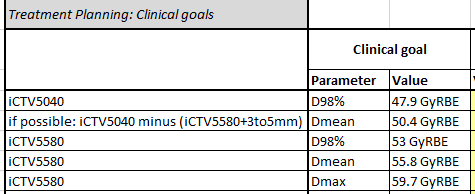

•	Dmean = Dpres

•	D98% ≥ 95% of Dpres

•	Dmax < 107% of Dpres






In [ ]:
biol_dose_cube = pt.DosCube()
biol_dose_cube2 = pt.DosCube()

In [ ]:
biol_dose_cube.cube = rbe_wedenberg(dos_cube.cube[mask], let_cube.cube[mask], ab, q_val.q.median()) * dos_cube.cube[mask] 
biol_dose_cube2.cube = rbe_wedenberg(dos_cube2.cube[mask], let_cube2.cube[mask], ab, q_val.q.median()) * dos_cube2.cube[mask] 

In [ ]:
biol_dose_cube.cube = biol_dose_cube.cube/biol_dose_cube.cube.max()*dose_pres
biol_dose_cube2.cube=biol_dose_cube2.cube/biol_dose_cube2.cube.max()*dose_pres

In [ ]:
biol_dose_cube.cube.mean()

In [ ]:

def checkV98_D95(doseToCheck,dose95):
  if doseToCheck >= dose95 :
    print("98% objętości otrzymało dawkę większą niż 95% dawki zalecanej",round(doseToCheck,2),"Gy",">",round(dose95,2),"Gy")
  else:
   print("98% objętości NIE otrzymało odpowiedniej dawki",round(doseToCheck,2),"Gy","<",round(dose95,2),"Gy")

def checkDmax (doseToCheck,dose107):
  if doseToCheck > dose107:
    print("Za wysoka dawka maksymalna",round(doseToCheck,2),"Gy",">",round(dose107,2),"Gy")
  else:
    print("OK! Dawka maksymalna jest mniejsza niż 107% dawki przepisanej",round(doseToCheck,2),"Gy","<",round(dose107,2),"Gy")

def checkDmean(doseToCheck,dose_pres):
  if doseToCheck >dose_pres:
    print("Za wysoka dawka średnia w całej objętości nowotworu",round(doseToCheck,2),"Gy",">",round(dose_pres,2),"Gy")
  elif doseToCheck <dose_pres:
    print("Średnia dawka w nowotworze jest za mała",round(doseToCheck,2),"Gy","<",round(dose_pres,2),"Gy")
  else :
    print("OK! Średnia dawka jest równa dawce przepisanej",round(doseToCheck,2),"Gy")

In [ ]:
print("iCTV5580")
print("Prescribe Dose =" , round(dose_pres,2),"Gy" ," in 31fr")
dose107= dose_pres*1.07
print("107%Dose: ", round(dose107,2)  ,"Gy")
dose95=dose_pres*0.95
print("95%Dose: ", round(dose95,2)  ,"Gy")

print("\nPlan 1")
checkV98_D95(dvh_mean[0][dvh_mean[1]>98][-1]*31.,dose95)
checkDmean(biol_dose_cube.cube.mean(),dose_pres)
checkDmax(biol_dose_cube.cube.max(),dose107)
2
print("\nPlan 2")
checkV98_D95(dvh2_mean[0][dvh2_mean[1]>98][-1]*31.,dose95)
checkDmean(biol_dose_cube2.cube.mean(),dose_pres)
checkDmax(biol_dose_cube2.cube.max(),dose107)

print("\nWedenberg Plan 1")
checkV98_D95(dvh_wed[0][dvh_wed[1][dvh_wed[1]>=98].size]*31,dose95)
checkDmean(dvh_wed[0].mean(),dose_pres)
checkDmax(dvh_wed[0].max(),dose107)

